# Q1 Using the same number of points =30 and add

In [1]:
pip install numpy matplotlib pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=2ac4d113e5feea8cb2f75826d5c205a8c764637771f8fd881a5f6ba0093adf1d
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE
Note: you may need to restart the kernel to use updated packages.


# Q1 PART A

# 30 Data Points

Training data-only model...
Epoch 0: Train Loss = 0.599385, Test Loss = 0.509999
Epoch 500: Train Loss = 0.004107, Test Loss = 0.007066
Epoch 1000: Train Loss = 0.002456, Test Loss = 0.004274
Epoch 1500: Train Loss = 0.001697, Test Loss = 0.002873
Epoch 2000: Train Loss = 0.000455, Test Loss = 0.001556
Epoch 2500: Train Loss = 0.000173, Test Loss = 0.003205
Epoch 3000: Train Loss = 0.000119, Test Loss = 0.003023
Epoch 3500: Train Loss = 0.000093, Test Loss = 0.002983
Epoch 4000: Train Loss = 0.000079, Test Loss = 0.003018
Epoch 4500: Train Loss = 0.000069, Test Loss = 0.003057

Training physics-informed model...
Epoch 0: Train Loss = 0.582851, Test Loss = 0.416224
Epoch 500: Train Loss = 0.013333, Test Loss = 0.016488
Epoch 1000: Train Loss = 0.008452, Test Loss = 0.015799
Epoch 1500: Train Loss = 0.006080, Test Loss = 0.016369
Epoch 2000: Train Loss = 0.003425, Test Loss = 0.014830
Epoch 2500: Train Loss = 0.002857, Test Loss = 0.013914
Epoch 3000: Train Loss = 0.003298, Test Loss = 0

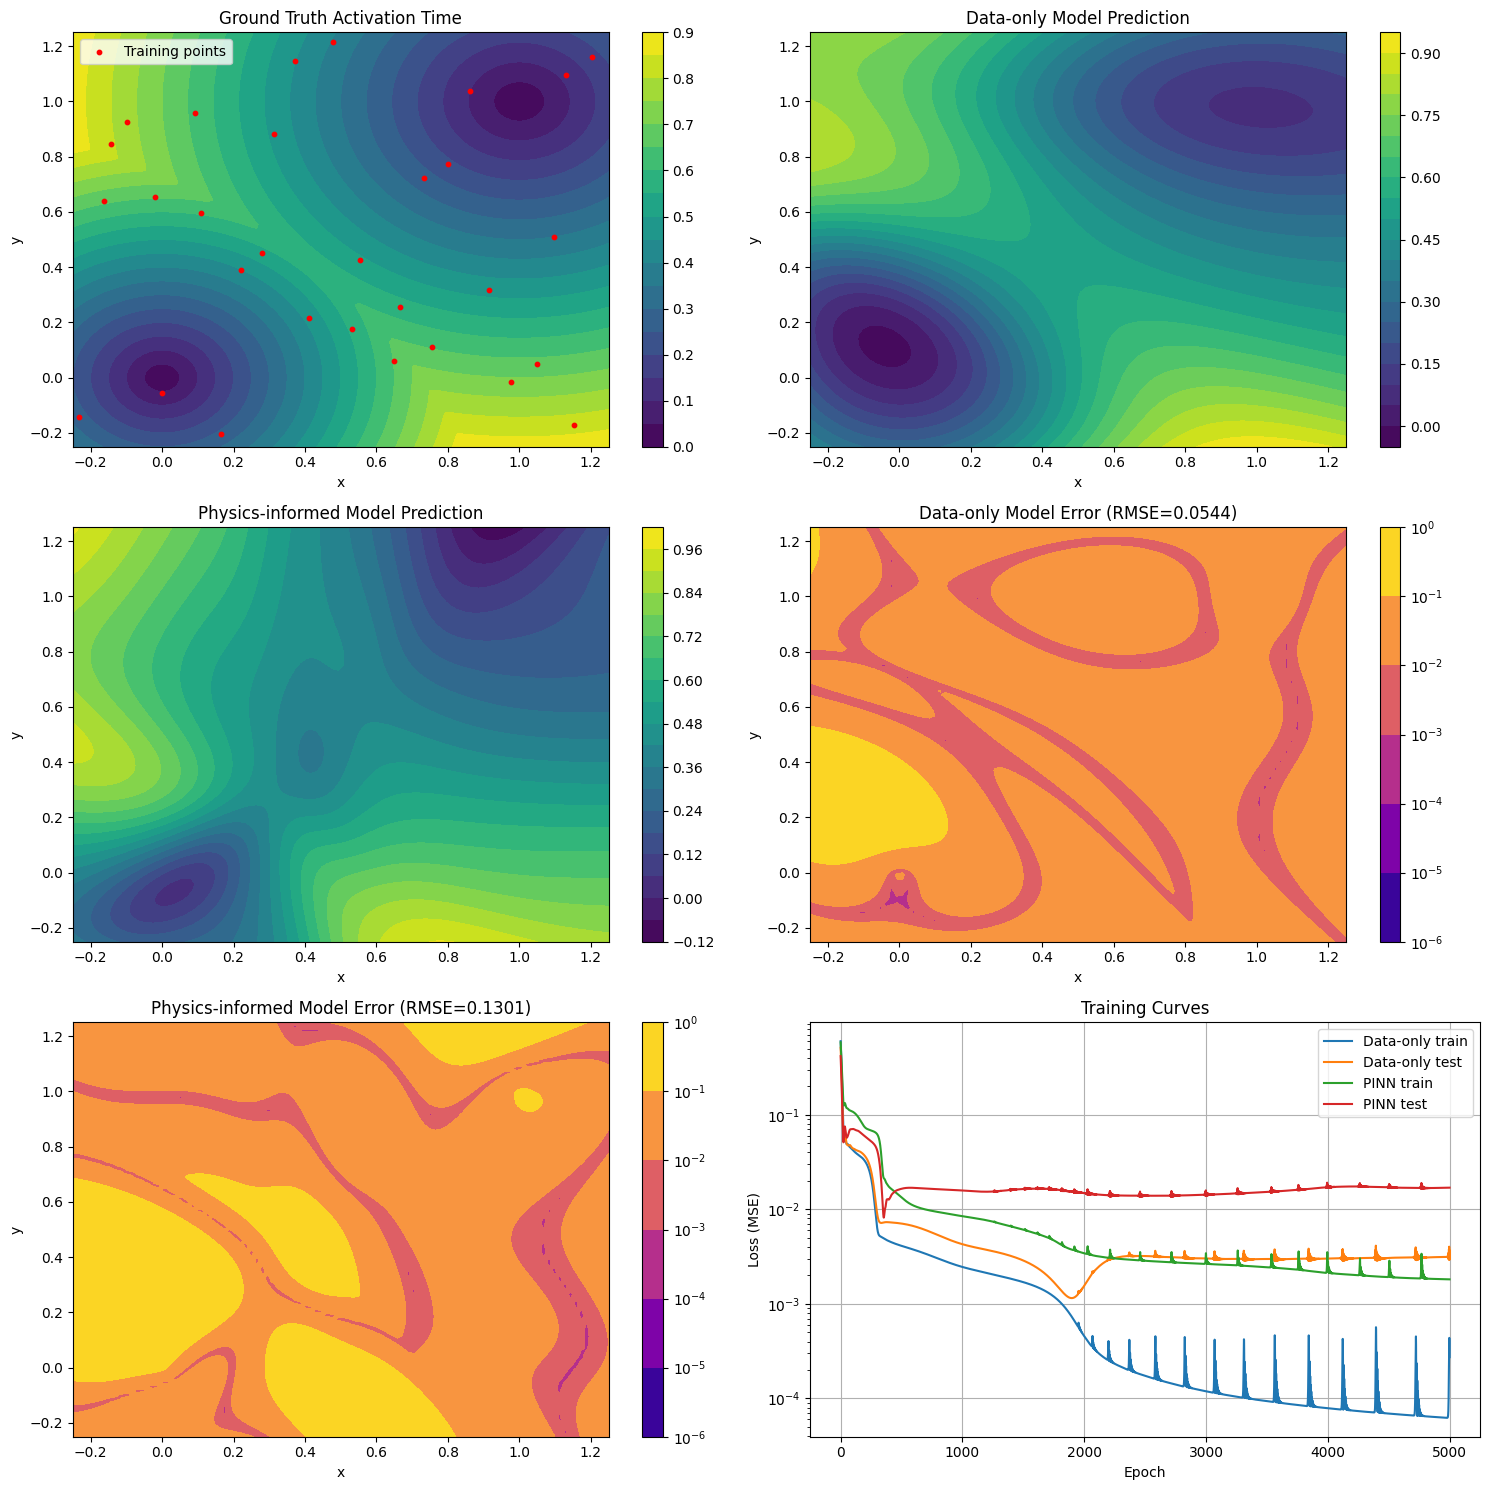

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from pyDOE import lhs
import matplotlib.colors as colors

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Part A: Data Generation
def generate_true_solution(x, y):
    """Compute the true T(x,y) based on the given formula"""
    term1 = np.sqrt(x**2 + y**2)
    term2 = 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2)
    return np.minimum(term1, term2)

def generate_velocity_field(x, y):
    """Compute the conduction velocity V(x,y)"""
    term1 = np.sqrt(x**2 + y**2)
    term2 = 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2)
    return np.where(term1 < term2, 1.0, 1/0.7)

def generate_data(n_samples=30, method='lhs'):
    """Generate training data using Latin Hypercube Sampling or random sampling"""
    if method == 'lhs':
        samples = lhs(2, samples=n_samples)  # 2D space
        x = samples[:, 0] * 1.5 - 0.25  # Scale to cover interesting region
        y = samples[:, 1] * 1.5 - 0.25
    else:
        x = np.random.uniform(-0.25, 1.25, n_samples)
        y = np.random.uniform(-0.25, 1.25, n_samples)
    
    T = generate_true_solution(x, y)
    V = generate_velocity_field(x, y)
    
    return x, y, T, V

# Generate data
n_samples = 30
x_train, y_train, T_train, V_train = generate_data(n_samples, method='lhs')

# Convert to PyTorch tensors
X_train = torch.tensor(np.column_stack((x_train, y_train)), dtype=torch.float32)
T_train = torch.tensor(T_train, dtype=torch.float32).view(-1, 1)
V_train = torch.tensor(V_train, dtype=torch.float32).view(-1, 1)

# Create test grid for evaluation
xx, yy = np.meshgrid(np.linspace(-0.25, 1.25, 100), np.linspace(-0.25, 1.25, 100))
X_test = np.column_stack((xx.ravel(), yy.ravel()))
T_test = generate_true_solution(xx, yy)
V_test = generate_velocity_field(xx, yy)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
T_test_tensor = torch.tensor(T_test.ravel(), dtype=torch.float32).view(-1, 1)
V_test_tensor = torch.tensor(V_test.ravel(), dtype=torch.float32).view(-1, 1)

# Part B: Model Definition
class EikonalNet(nn.Module):
    """Neural network for approximating T(x,y)"""
    def __init__(self, hidden_layers=4, hidden_units=20):
        super(EikonalNet, self).__init__()
        layers = [nn.Linear(2, hidden_units), nn.Tanh()]
        
        for _ in range(hidden_layers - 1):
            layers.extend([nn.Linear(hidden_units, hidden_units), nn.Tanh()])
        
        layers.append(nn.Linear(hidden_units, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

def compute_gradient(model, x):
    """Compute ∇T(x,y) using automatic differentiation"""
    x.requires_grad_(True)
    T = model(x)
    grad_T = torch.autograd.grad(T.sum(), x, create_graph=True)[0]
    return grad_T

def eikonal_residual(model, x, V):
    """Compute the Eikonal residual V(x,y)∥∇T(x,y)∥ - 1"""
    grad_T = compute_gradient(model, x)
    norm_grad_T = torch.norm(grad_T, dim=1, keepdim=True)
    return V * norm_grad_T - 1

# Training function
def train_model(model, X_train, T_train, V_train, X_test, T_test, V_test, 
                epochs=5000, lr=0.001, physics_weight=0.1, physics_informed=False):
    """Train the model with or without physics-informed loss"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, T_train, V_train)
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for X_batch, T_batch, V_batch in train_loader:
            optimizer.zero_grad()
            
            # Data loss
            T_pred = model(X_batch)
            data_loss = nn.functional.mse_loss(T_pred, T_batch)
            
            if physics_informed:
                # Physics loss
                residual = eikonal_residual(model, X_batch, V_batch)
                physics_loss = torch.mean(residual**2)
                
                # Combined loss
                loss = data_loss + physics_weight * physics_loss
            else:
                loss = data_loss
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            T_pred_test = model(X_test)
            test_loss = nn.functional.mse_loss(T_pred_test, T_test).item()
        
        train_losses.append(total_loss / len(train_loader))
        test_losses.append(test_loss)
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.6f}, Test Loss = {test_losses[-1]:.6f}")
    
    return train_losses, test_losses

# Initialize models
model_data_only = EikonalNet(hidden_layers=4, hidden_units=20)
model_physics_informed = EikonalNet(hidden_layers=4, hidden_units=20)

# Train models
print("Training data-only model...")
train_loss_data, test_loss_data = train_model(
    model_data_only, X_train, T_train, V_train, X_test_tensor, T_test_tensor, V_test_tensor,
    epochs=5000, physics_informed=False
)

print("\nTraining physics-informed model...")
train_loss_pinn, test_loss_pinn = train_model(
    model_physics_informed, X_train, T_train, V_train, X_test_tensor, T_test_tensor, V_test_tensor,
    epochs=5000, physics_informed=True, physics_weight=0.1
)

# Part C: Evaluation and Visualization
def evaluate_model(model, X_test, grid_shape):
    """Evaluate model on test grid"""
    with torch.no_grad():
        T_pred = model(X_test).numpy().reshape(grid_shape)
    return T_pred

# Get predictions
T_pred_data = evaluate_model(model_data_only, X_test_tensor, xx.shape)
T_pred_pinn = evaluate_model(model_physics_informed, X_test_tensor, xx.shape)

# Calculate errors
error_data = np.abs(T_pred_data - T_test)
error_pinn = np.abs(T_pred_pinn - T_test)
rmse_data = np.sqrt(np.mean(error_data**2))
rmse_pinn = np.sqrt(np.mean(error_pinn**2))

print(f"\nRMSE Data-only model: {rmse_data:.6f}")
print(f"RMSE Physics-informed model: {rmse_pinn:.6f}")

# Create plots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# True solution
im0 = axes[0, 0].contourf(xx, yy, T_test, levels=20, cmap='viridis')
axes[0, 0].scatter(x_train, y_train, c='red', s=10, label='Training points')
axes[0, 0].set_title('Ground Truth Activation Time')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
axes[0, 0].legend()
plt.colorbar(im0, ax=axes[0, 0])

# Data-only prediction
im1 = axes[0, 1].contourf(xx, yy, T_pred_data, levels=20, cmap='viridis')
axes[0, 1].set_title('Data-only Model Prediction')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
plt.colorbar(im1, ax=axes[0, 1])

# Physics-informed prediction
im2 = axes[1, 0].contourf(xx, yy, T_pred_pinn, levels=20, cmap='viridis')
axes[1, 0].set_title('Physics-informed Model Prediction')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(im2, ax=axes[1, 0])

# Data-only error
im3 = axes[1, 1].contourf(xx, yy, error_data, levels=20, cmap='plasma', norm=colors.LogNorm())
axes[1, 1].set_title(f'Data-only Model Error (RMSE={rmse_data:.4f})')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(im3, ax=axes[1, 1])

# Physics-informed error
im4 = axes[2, 0].contourf(xx, yy, error_pinn, levels=20, cmap='plasma', norm=colors.LogNorm())
axes[2, 0].set_title(f'Physics-informed Model Error (RMSE={rmse_pinn:.4f})')
axes[2, 0].set_xlabel('x')
axes[2, 0].set_ylabel('y')
plt.colorbar(im4, ax=axes[2, 0])

# Training curves
axes[2, 1].semilogy(train_loss_data, label='Data-only train')
axes[2, 1].semilogy(test_loss_data, label='Data-only test')
axes[2, 1].semilogy(train_loss_pinn, label='PINN train')
axes[2, 1].semilogy(test_loss_pinn, label='PINN test')
axes[2, 1].set_title('Training Curves')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss (MSE)')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

# 50 Data Points

Training data-only model...
Epoch 0: Train Loss = 0.505843, Test Loss = 0.509999
Epoch 500: Train Loss = 0.007224, Test Loss = 0.005054
Epoch 1000: Train Loss = 0.001729, Test Loss = 0.001473
Epoch 1500: Train Loss = 0.001013, Test Loss = 0.000857
Epoch 2000: Train Loss = 0.000751, Test Loss = 0.000746
Epoch 2500: Train Loss = 0.000627, Test Loss = 0.000668
Epoch 3000: Train Loss = 0.000548, Test Loss = 0.000612
Epoch 3500: Train Loss = 0.000494, Test Loss = 0.000571
Epoch 4000: Train Loss = 0.000453, Test Loss = 0.000543
Epoch 4500: Train Loss = 0.000420, Test Loss = 0.000525

Training physics-informed model...
Epoch 0: Train Loss = 0.498365, Test Loss = 0.416225
Epoch 500: Train Loss = 0.015904, Test Loss = 0.005041
Epoch 1000: Train Loss = 0.010725, Test Loss = 0.004349
Epoch 1500: Train Loss = 0.005957, Test Loss = 0.002758
Epoch 2000: Train Loss = 0.004734, Test Loss = 0.002596
Epoch 2500: Train Loss = 0.003914, Test Loss = 0.002310
Epoch 3000: Train Loss = 0.002886, Test Loss = 0

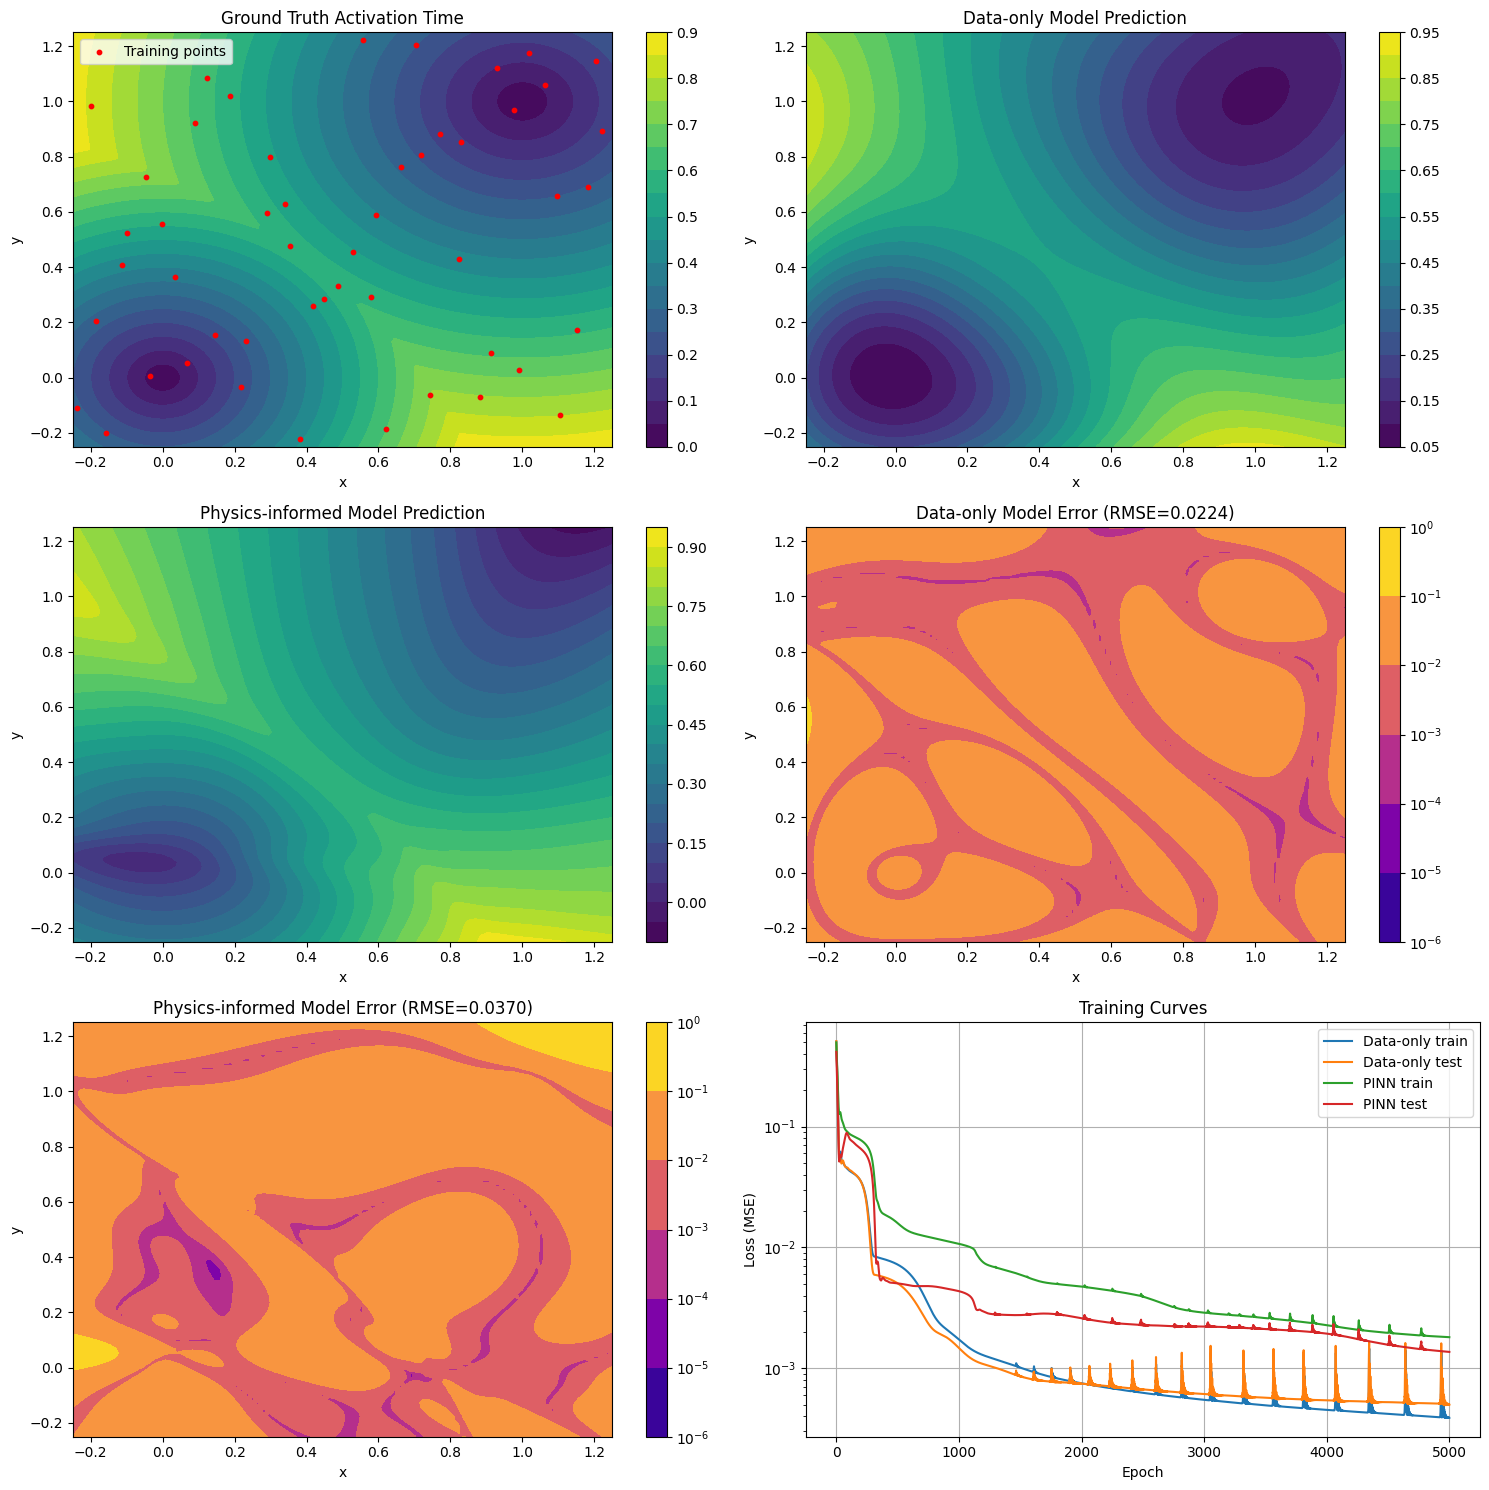

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from pyDOE import lhs
import matplotlib.colors as colors

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Part A: Data Generation
def generate_true_solution(x, y):
    """Compute the true T(x,y) based on the given formula"""
    term1 = np.sqrt(x**2 + y**2)
    term2 = 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2)
    return np.minimum(term1, term2)

def generate_velocity_field(x, y):
    """Compute the conduction velocity V(x,y)"""
    term1 = np.sqrt(x**2 + y**2)
    term2 = 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2)
    return np.where(term1 < term2, 1.0, 1/0.7)

def generate_data(n_samples=30, method='lhs'):
    """Generate training data using Latin Hypercube Sampling or random sampling"""
    if method == 'lhs':
        samples = lhs(2, samples=n_samples)  # 2D space
        x = samples[:, 0] * 1.5 - 0.25  # Scale to cover interesting region
        y = samples[:, 1] * 1.5 - 0.25
    else:
        x = np.random.uniform(-0.25, 1.25, n_samples)
        y = np.random.uniform(-0.25, 1.25, n_samples)
    
    T = generate_true_solution(x, y)
    V = generate_velocity_field(x, y)
    
    return x, y, T, V

# Generate data
n_samples = 50
x_train, y_train, T_train, V_train = generate_data(n_samples, method='lhs')

# Convert to PyTorch tensors
X_train = torch.tensor(np.column_stack((x_train, y_train)), dtype=torch.float32)
T_train = torch.tensor(T_train, dtype=torch.float32).view(-1, 1)
V_train = torch.tensor(V_train, dtype=torch.float32).view(-1, 1)

# Create test grid for evaluation
xx, yy = np.meshgrid(np.linspace(-0.25, 1.25, 100), np.linspace(-0.25, 1.25, 100))
X_test = np.column_stack((xx.ravel(), yy.ravel()))
T_test = generate_true_solution(xx, yy)
V_test = generate_velocity_field(xx, yy)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
T_test_tensor = torch.tensor(T_test.ravel(), dtype=torch.float32).view(-1, 1)
V_test_tensor = torch.tensor(V_test.ravel(), dtype=torch.float32).view(-1, 1)

# Part B: Model Definition
class EikonalNet(nn.Module):
    """Neural network for approximating T(x,y)"""
    def __init__(self, hidden_layers=4, hidden_units=20):
        super(EikonalNet, self).__init__()
        layers = [nn.Linear(2, hidden_units), nn.Tanh()]
        
        for _ in range(hidden_layers - 1):
            layers.extend([nn.Linear(hidden_units, hidden_units), nn.Tanh()])
        
        layers.append(nn.Linear(hidden_units, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

def compute_gradient(model, x):
    """Compute ∇T(x,y) using automatic differentiation"""
    x.requires_grad_(True)
    T = model(x)
    grad_T = torch.autograd.grad(T.sum(), x, create_graph=True)[0]
    return grad_T

def eikonal_residual(model, x, V):
    """Compute the Eikonal residual V(x,y)∥∇T(x,y)∥ - 1"""
    grad_T = compute_gradient(model, x)
    norm_grad_T = torch.norm(grad_T, dim=1, keepdim=True)
    return V * norm_grad_T - 1

# Training function
def train_model(model, X_train, T_train, V_train, X_test, T_test, V_test, 
                epochs=5000, lr=0.001, physics_weight=0.1, physics_informed=False):
    """Train the model with or without physics-informed loss"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, T_train, V_train)
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for X_batch, T_batch, V_batch in train_loader:
            optimizer.zero_grad()
            
            # Data loss
            T_pred = model(X_batch)
            data_loss = nn.functional.mse_loss(T_pred, T_batch)
            
            if physics_informed:
                # Physics loss
                residual = eikonal_residual(model, X_batch, V_batch)
                physics_loss = torch.mean(residual**2)
                
                # Combined loss
                loss = data_loss + physics_weight * physics_loss
            else:
                loss = data_loss
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            T_pred_test = model(X_test)
            test_loss = nn.functional.mse_loss(T_pred_test, T_test).item()
        
        train_losses.append(total_loss / len(train_loader))
        test_losses.append(test_loss)
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.6f}, Test Loss = {test_losses[-1]:.6f}")
    
    return train_losses, test_losses

# Initialize models
model_data_only = EikonalNet(hidden_layers=4, hidden_units=20)
model_physics_informed = EikonalNet(hidden_layers=4, hidden_units=20)

# Train models
print("Training data-only model...")
train_loss_data, test_loss_data = train_model(
    model_data_only, X_train, T_train, V_train, X_test_tensor, T_test_tensor, V_test_tensor,
    epochs=5000, physics_informed=False
)

print("\nTraining physics-informed model...")
train_loss_pinn, test_loss_pinn = train_model(
    model_physics_informed, X_train, T_train, V_train, X_test_tensor, T_test_tensor, V_test_tensor,
    epochs=5000, physics_informed=True, physics_weight=0.1
)

# Part C: Evaluation and Visualization
def evaluate_model(model, X_test, grid_shape):
    """Evaluate model on test grid"""
    with torch.no_grad():
        T_pred = model(X_test).numpy().reshape(grid_shape)
    return T_pred

# Get predictions
T_pred_data = evaluate_model(model_data_only, X_test_tensor, xx.shape)
T_pred_pinn = evaluate_model(model_physics_informed, X_test_tensor, xx.shape)

# Calculate errors
error_data = np.abs(T_pred_data - T_test)
error_pinn = np.abs(T_pred_pinn - T_test)
rmse_data = np.sqrt(np.mean(error_data**2))
rmse_pinn = np.sqrt(np.mean(error_pinn**2))

print(f"\nRMSE Data-only model: {rmse_data:.6f}")
print(f"RMSE Physics-informed model: {rmse_pinn:.6f}")

# Create plots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# True solution
im0 = axes[0, 0].contourf(xx, yy, T_test, levels=20, cmap='viridis')
axes[0, 0].scatter(x_train, y_train, c='red', s=10, label='Training points')
axes[0, 0].set_title('Ground Truth Activation Time')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
axes[0, 0].legend()
plt.colorbar(im0, ax=axes[0, 0])

# Data-only prediction
im1 = axes[0, 1].contourf(xx, yy, T_pred_data, levels=20, cmap='viridis')
axes[0, 1].set_title('Data-only Model Prediction')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
plt.colorbar(im1, ax=axes[0, 1])

# Physics-informed prediction
im2 = axes[1, 0].contourf(xx, yy, T_pred_pinn, levels=20, cmap='viridis')
axes[1, 0].set_title('Physics-informed Model Prediction')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(im2, ax=axes[1, 0])

# Data-only error
im3 = axes[1, 1].contourf(xx, yy, error_data, levels=20, cmap='plasma', norm=colors.LogNorm())
axes[1, 1].set_title(f'Data-only Model Error (RMSE={rmse_data:.4f})')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(im3, ax=axes[1, 1])

# Physics-informed error
im4 = axes[2, 0].contourf(xx, yy, error_pinn, levels=20, cmap='plasma', norm=colors.LogNorm())
axes[2, 0].set_title(f'Physics-informed Model Error (RMSE={rmse_pinn:.4f})')
axes[2, 0].set_xlabel('x')
axes[2, 0].set_ylabel('y')
plt.colorbar(im4, ax=axes[2, 0])

# Training curves
axes[2, 1].semilogy(train_loss_data, label='Data-only train')
axes[2, 1].semilogy(test_loss_data, label='Data-only test')
axes[2, 1].semilogy(train_loss_pinn, label='PINN train')
axes[2, 1].semilogy(test_loss_pinn, label='PINN test')
axes[2, 1].set_title('Training Curves')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss (MSE)')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

In [11]:
pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.

In [2]:
pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=ede666035373537161f7529b6ae620bbc6ed374fd7f380da5a2f49e57da17346
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE
Note: you may need to restart the kernel to use updated packages.


# Question 2

# Blobs datasets

Using device: cuda
Training data shape: torch.Size([400, 2]), Labels shape: torch.Size([400])
Test data shape: torch.Size([100, 2]), Labels shape: torch.Size([100])
--- Part A: Training Standard Neural Network ---
NN Epoch [50/500], Loss: 0.0022, Test Acc: 100.00%
NN Epoch [100/500], Loss: 0.0008, Test Acc: 100.00%
NN Epoch [150/500], Loss: 0.0005, Test Acc: 100.00%
NN Epoch [200/500], Loss: 0.0003, Test Acc: 100.00%
NN Epoch [250/500], Loss: 0.0002, Test Acc: 100.00%
NN Epoch [300/500], Loss: 0.0002, Test Acc: 100.00%
NN Epoch [350/500], Loss: 0.0001, Test Acc: 100.00%
NN Epoch [400/500], Loss: 0.0001, Test Acc: 100.00%
NN Epoch [450/500], Loss: 0.0001, Test Acc: 100.00%
NN Epoch [500/500], Loss: 0.0001, Test Acc: 100.00%

Standard NN Training Accuracy: 100.00%
Standard NN Test Accuracy: 100.00%


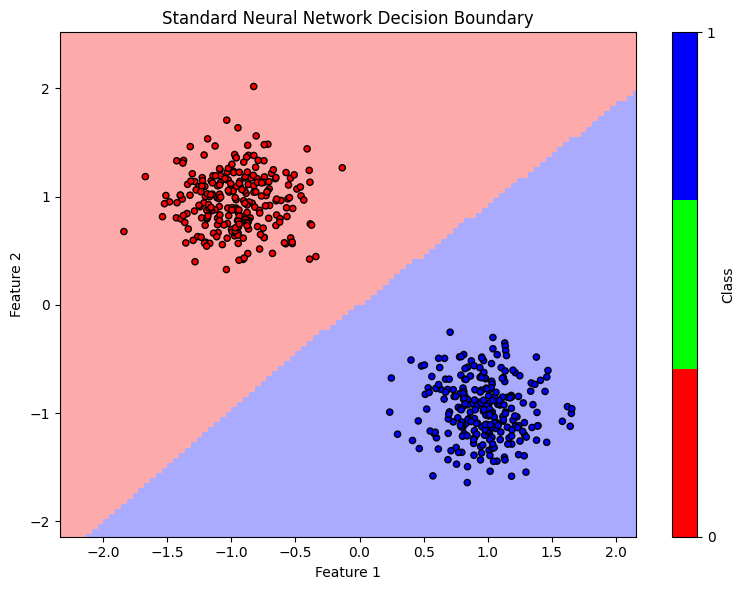


--- Part B: Training Neural ODE Model ---
ODE Epoch [50/500], Loss: 0.0000, Test Acc: 100.00%
ODE Epoch [100/500], Loss: 0.0000, Test Acc: 100.00%
ODE Epoch [150/500], Loss: 0.0000, Test Acc: 100.00%
ODE Epoch [200/500], Loss: 0.0000, Test Acc: 100.00%
ODE Epoch [250/500], Loss: 0.0000, Test Acc: 100.00%
ODE Epoch [300/500], Loss: 0.0000, Test Acc: 100.00%
ODE Epoch [350/500], Loss: 0.0000, Test Acc: 100.00%
ODE Epoch [400/500], Loss: 0.0000, Test Acc: 100.00%
ODE Epoch [450/500], Loss: 0.0000, Test Acc: 100.00%
ODE Epoch [500/500], Loss: 0.0000, Test Acc: 100.00%

Neural ODE Training Accuracy: 100.00%
Neural ODE Test Accuracy: 100.00%


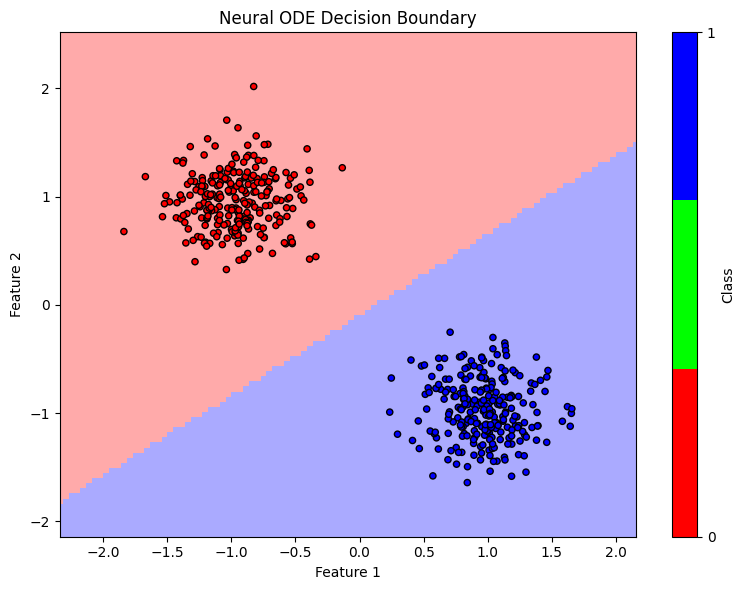


--- Part C: Model Performance Comparison ---
Standard NN Training Accuracy: 100.00%
Standard NN Test Accuracy: 100.00%
Neural ODE Training Accuracy: 100.00%
Neural ODE Test Accuracy: 100.00%


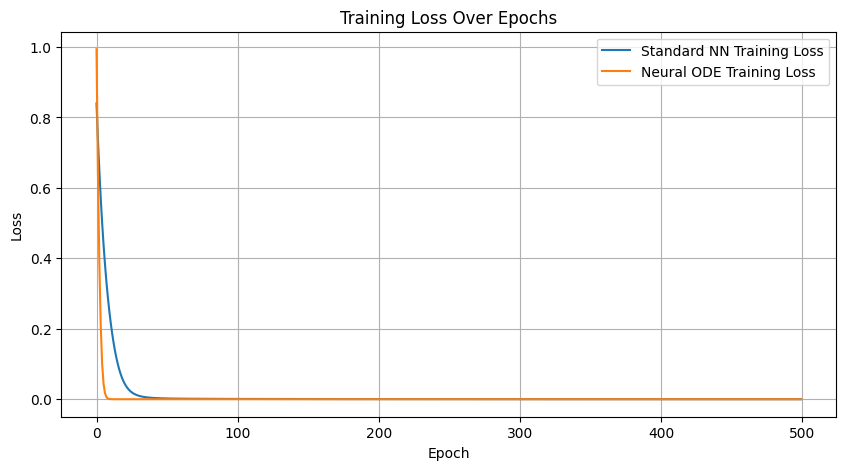

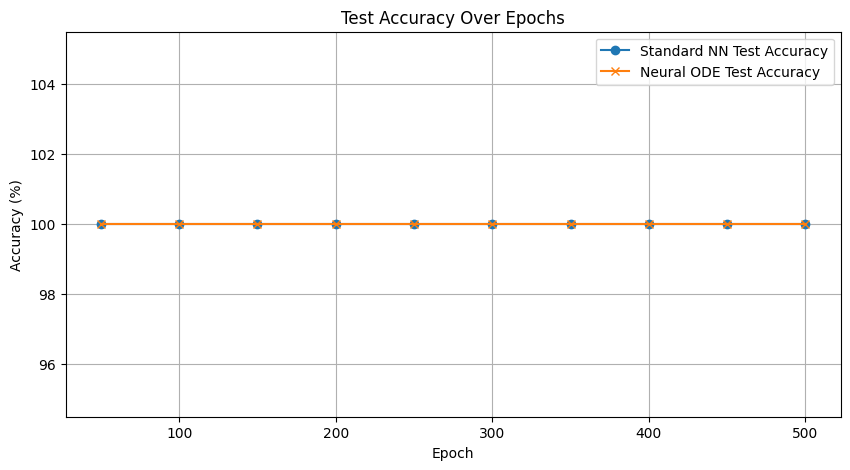

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torchdiffeq import odeint_adjoint as odeint # Using adjoint for memory efficiency

# --- Configuration and Setup ---
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset selection
# Choose one of the following by uncommenting:
# X, y = make_moons(n_samples=500, noise=0.15, random_state=42)
# X, y = make_circles(n_samples=500, noise=0.05, factor=0.5, random_state=42)
X, y = make_blobs(n_samples=500, centers=2, cluster_std=1.0, random_state=42)


# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors and move to device
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.long).to(device)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")

# Model parameters
input_dim = X_train.shape[1]
hidden_dim = 32  # Recommended between 16-32 neurons for toy datasets
output_dim = len(torch.unique(y_train)) # Number of classes

num_epochs = 500
learning_rate = 0.01

# --- Helper Functions ---
def calculate_accuracy(model, X, y):
    """Calculates accuracy of the model on given data."""
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculations
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total = y.size(0)
        correct = (predicted == y).sum().item()
        accuracy = 100 * correct / total
    return accuracy

def plot_decision_boundary(model, X_plot, y_plot, title):
    """Visualizes the decision boundary of a 2D classification model."""
    x_min, x_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
    y_min, y_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        Z = model(grid).argmax(dim=1).reshape(xx.shape).cpu().numpy() # Move to CPU for numpy

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFaa', '#AAAAFF']) # Added a third color just in case
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Plot also the data points
    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    # Add a colorbar for clarity if more than 2 classes
    if output_dim > 1:
        plt.colorbar(ticks=range(output_dim), label="Class")
    plt.tight_layout()
    plt.show()

# --- Part A: Standard Neural Network ---
print("--- Part A: Training Standard Neural Network ---")

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model_nn = SimpleNN(input_dim, hidden_dim, output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_nn = optim.Adam(model_nn.parameters(), lr=learning_rate)

# Training loop for Standard NN
train_losses_nn = []
test_accuracies_nn = []

for epoch in range(num_epochs):
    model_nn.train() # Set model to training mode
    optimizer_nn.zero_grad()
    outputs = model_nn(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer_nn.step()

    train_losses_nn.append(loss.item())

    if (epoch + 1) % 50 == 0:
        test_acc = calculate_accuracy(model_nn, X_test, y_test)
        test_accuracies_nn.append(test_acc)
        print(f'NN Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Acc: {test_acc:.2f}%')

# Final evaluation for Standard NN
train_accuracy_nn = calculate_accuracy(model_nn, X_train, y_train)
test_accuracy_nn = calculate_accuracy(model_nn, X_test, y_test)

print(f'\nStandard NN Training Accuracy: {train_accuracy_nn:.2f}%')
print(f'Standard NN Test Accuracy: {test_accuracy_nn:.2f}%')

# Visualize decision boundaries (using CPU numpy arrays for plotting)
plot_decision_boundary(model_nn, X_tensor.cpu().numpy(), y_tensor.cpu().numpy(), 'Standard Neural Network Decision Boundary')

# --- Part B: Neural Ordinary Differential Equation (Neural ODE) ---
print("\n--- Part B: Training Neural ODE Model ---")

class ODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(ODEFunc, self).__init__()
        # f(h, t) is a small neural network
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 16), # Layer 1
            nn.ReLU(),
            nn.Linear(16, hidden_dim)  # Layer 2
        )

    def forward(self, t, h):
        # t is passed by odeint, but for a time-invariant ODE, f typically doesn't directly use it
        return self.net(h)

class NeuralODE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralODE, self).__init__()
        self.initial_layer = nn.Linear(input_dim, hidden_dim)
        self.ode_func = ODEFunc(hidden_dim)
        # Define the time interval for the ODE solver [t0, t1]
        self.time_points = torch.tensor([0., 1.], dtype=torch.float32).to(device)
        self.final_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initial transformation from input to the hidden state at t=0
        h0 = self.initial_layer(x)

        # Evolve the hidden state over the time interval using an ODE solver
        # odeint_adjoint is preferred for memory efficiency in backprop
        # 'dopri5' is generally a good adaptive solver, 'rk4' is simpler.
        # [1] selects the state at the final time point (t=1 in this case)
        h_final = odeint(self.ode_func, h0, self.time_points, method='dopri5')[1]

        # Final classification layer
        out = self.final_layer(h_final)
        return out

model_ode = NeuralODE(input_dim, hidden_dim, output_dim).to(device)

optimizer_ode = optim.Adam(model_ode.parameters(), lr=learning_rate)

# Training loop for Neural ODE
train_losses_ode = []
test_accuracies_ode = []

for epoch in range(num_epochs):
    model_ode.train()
    optimizer_ode.zero_grad()
    outputs = model_ode(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer_ode.step()

    train_losses_ode.append(loss.item())

    if (epoch + 1) % 50 == 0:
        test_acc = calculate_accuracy(model_ode, X_test, y_test)
        test_accuracies_ode.append(test_acc)
        print(f'ODE Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Acc: {test_acc:.2f}%')

# Final evaluation for Neural ODE
train_accuracy_ode = calculate_accuracy(model_ode, X_train, y_train)
test_accuracy_ode = calculate_accuracy(model_ode, X_test, y_test)

print(f'\nNeural ODE Training Accuracy: {train_accuracy_ode:.2f}%')
print(f'Neural ODE Test Accuracy: {test_accuracy_ode:.2f}%')

plot_decision_boundary(model_ode, X_tensor.cpu().numpy(), y_tensor.cpu().numpy(), 'Neural ODE Decision Boundary')


# --- Part C: Comparison and Discussion ---
print("\n--- Part C: Model Performance Comparison ---")
print(f"Standard NN Training Accuracy: {train_accuracy_nn:.2f}%")
print(f"Standard NN Test Accuracy: {test_accuracy_nn:.2f}%")
print(f"Neural ODE Training Accuracy: {train_accuracy_ode:.2f}%")
print(f"Neural ODE Test Accuracy: {test_accuracy_ode:.2f}%")

# Plotting loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses_nn)), train_losses_nn, label='Standard NN Training Loss')
plt.plot(range(len(train_losses_ode)), train_losses_ode, label='Neural ODE Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting test accuracy over tracked epochs (every 50 epochs in this case)
epochs_for_plot = [(i + 1) * 50 for i in range(len(test_accuracies_nn))] # Assuming tracking every 50 epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs_for_plot, test_accuracies_nn, marker='o', label='Standard NN Test Accuracy')
plt.plot(epochs_for_plot, test_accuracies_ode, marker='x', label='Neural ODE Test Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

# Moons Data

Training Standard Neural Network...
Epoch 0: Train Loss: 0.4699, Test Loss: 0.3534
           Train Acc: 0.8300, Test Acc: 0.8350
Epoch 10: Train Loss: 0.0658, Test Loss: 0.0588
           Train Acc: 0.9825, Test Acc: 0.9850
Epoch 20: Train Loss: 0.0223, Test Loss: 0.0183
           Train Acc: 0.9962, Test Acc: 1.0000
Epoch 30: Train Loss: 0.0122, Test Loss: 0.0092
           Train Acc: 0.9988, Test Acc: 1.0000
Epoch 40: Train Loss: 0.0079, Test Loss: 0.0068
           Train Acc: 1.0000, Test Acc: 1.0000
Epoch 50: Train Loss: 0.0056, Test Loss: 0.0040
           Train Acc: 1.0000, Test Acc: 1.0000
Epoch 60: Train Loss: 0.0042, Test Loss: 0.0046
           Train Acc: 1.0000, Test Acc: 1.0000
Epoch 70: Train Loss: 0.0034, Test Loss: 0.0033
           Train Acc: 1.0000, Test Acc: 1.0000
Epoch 80: Train Loss: 0.0028, Test Loss: 0.0022
           Train Acc: 1.0000, Test Acc: 1.0000
Epoch 90: Train Loss: 0.0023, Test Loss: 0.0021
           Train Acc: 1.0000, Test Acc: 1.0000

Training Neura

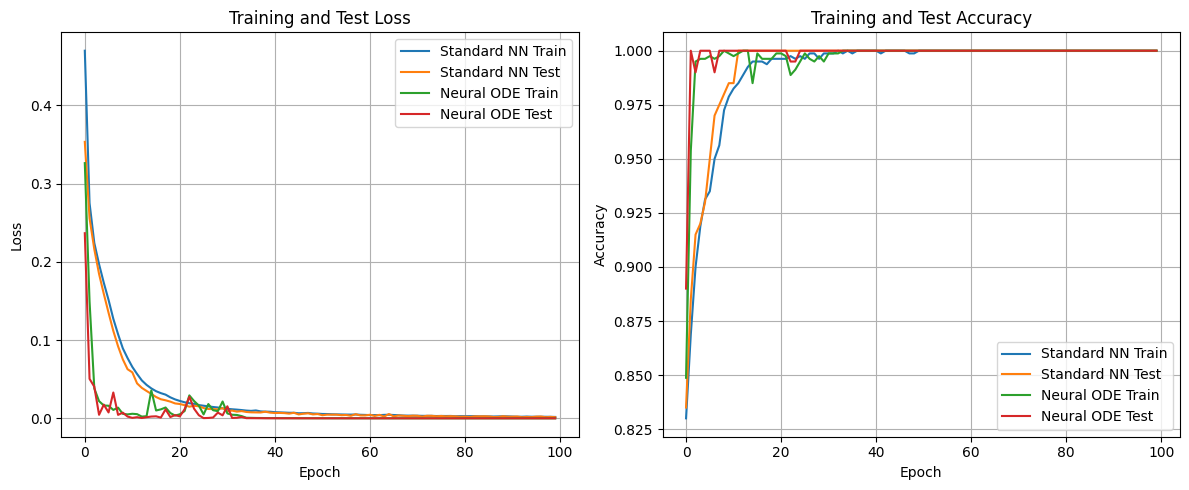

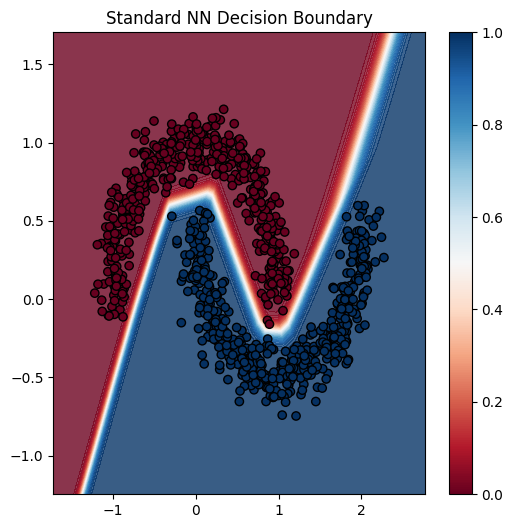

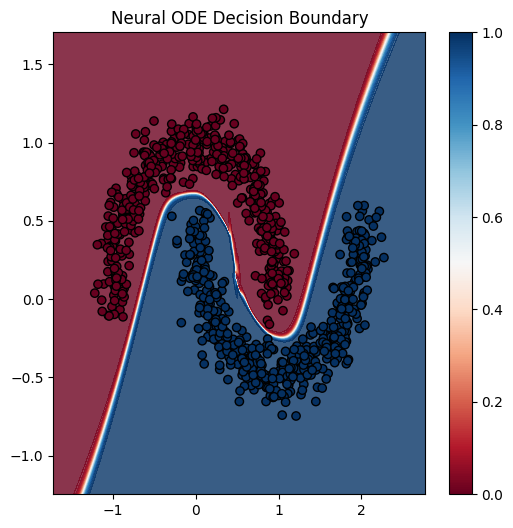


Final Performance Comparison:
Standard NN - Train Accuracy: 1.0000, Test Accuracy: 1.0000
Neural ODE  - Train Accuracy: 1.0000, Test Accuracy: 1.0000

Residual Connection vs Euler's Method:
Residual connection: h_{i+1} = h_i + f(h_i)
Euler's method: h(t + Δt) ≈ h(t) + Δt·f(h(t))

When Δt = 1, they become identical:
h_{i+1} = h_i + f(h_i)  ←→  h(t+1) ≈ h(t) + 1·f(h(t))

This shows that residual networks can be seen as Euler discretizations of ODEs!


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torchdiffeq import odeint
from sklearn.metrics import accuracy_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Part A: Standard Neural Network

# Create 2D toy dataset
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
X = X.astype(np.float32)
y = y.astype(np.float32)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train).view(-1, 1)
X_test_t = torch.tensor(X_test)
y_test_t = torch.tensor(y_test).view(-1, 1)

# Create dataloaders
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class StandardNN(nn.Module):
    """Standard neural network with one hidden layer"""
    def __init__(self, input_dim=2, hidden_dim=32, output_dim=1):
        super(StandardNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

def train_model(model, train_loader, test_loader, epochs=100, lr=0.01):
    """Training function for both models"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
        
        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total
        
        # Evaluate on test set
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                test_loss += criterion(outputs, targets).item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == targets).sum().item()
                total += targets.size(0)
        
        test_loss /= len(test_loader)
        test_acc = correct / total
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
            print(f"           Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    
    return train_losses, test_losses, train_accs, test_accs

# Train standard NN
print("Training Standard Neural Network...")
standard_nn = StandardNN(hidden_dim=32)
std_train_loss, std_test_loss, std_train_acc, std_test_acc = train_model(
    standard_nn, train_loader, test_loader, epochs=100, lr=0.01
)

## Part B: Neural ODE Model

class ODEFunc(nn.Module):
    """The ODE function f(h, t)"""
    def __init__(self, hidden_dim=32):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
    
    def forward(self, t, h):
        return self.net(h)

class NeuralODE(nn.Module):
    """Neural ODE model"""
    def __init__(self, input_dim=2, hidden_dim=32, output_dim=1):
        super(NeuralODE, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.ode_func = ODEFunc(hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, t=torch.tensor([0.0, 1.0])):
        # Initial transformation
        h0 = self.input_layer(x)
        
        # Solve ODE
        hs = odeint(self.ode_func, h0, t, method='rk4', rtol=1e-3, atol=1e-4)
        
        # Use final state for prediction
        hT = hs[-1]
        out = self.output_layer(hT)
        return self.sigmoid(out)

# Train Neural ODE
print("\nTraining Neural ODE...")
neural_ode = NeuralODE(hidden_dim=32)
node_train_loss, node_test_loss, node_train_acc, node_test_acc = train_model(
    neural_ode, train_loader, test_loader, epochs=100, lr=0.01
)

## Part C: Comparison and Visualization

# Plot training curves
plt.figure(figsize=(12, 5))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(std_train_loss, label='Standard NN Train')
plt.plot(std_test_loss, label='Standard NN Test')
plt.plot(node_train_loss, label='Neural ODE Train')
plt.plot(node_test_loss, label='Neural ODE Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(std_train_acc, label='Standard NN Train')
plt.plot(std_test_acc, label='Standard NN Test')
plt.plot(node_train_acc, label='Neural ODE Train')
plt.plot(node_test_acc, label='Neural ODE Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('comparison_curves.png', dpi=300)
plt.show()

# Plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    """Plot decision boundary for 2D data"""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    with torch.no_grad():
        if isinstance(model, NeuralODE):
            Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).numpy()
        else:
            Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).numpy()
    
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, levels=50, cmap='RdBu', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='k')
    plt.title(title)
    plt.colorbar()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()

# Plot decision boundaries
plot_decision_boundary(standard_nn, X, y, "Standard NN Decision Boundary")
plot_decision_boundary(neural_ode, X, y, "Neural ODE Decision Boundary")

# Print final metrics
print("\nFinal Performance Comparison:")
print(f"Standard NN - Train Accuracy: {std_train_acc[-1]:.4f}, Test Accuracy: {std_test_acc[-1]:.4f}")
print(f"Neural ODE  - Train Accuracy: {node_train_acc[-1]:.4f}, Test Accuracy: {node_test_acc[-1]:.4f}")

# Part C (Optional Bonus): Show Euler's method connection
def residual_connection_demo():
    """Demonstrate the connection between residual connections and Euler's method"""
    print("\nResidual Connection vs Euler's Method:")
    print("Residual connection: h_{i+1} = h_i + f(h_i)")
    print("Euler's method: h(t + Δt) ≈ h(t) + Δt·f(h(t))")
    print("\nWhen Δt = 1, they become identical:")
    print("h_{i+1} = h_i + f(h_i)  ←→  h(t+1) ≈ h(t) + 1·f(h(t))")
    print("\nThis shows that residual networks can be seen as Euler discretizations of ODEs!")

residual_connection_demo()